In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import zscore
from scipy.io import loadmat

In [2]:
ses = 1
sub = '04'
run = 1
num_trials = 90
trial_len = 9

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_path = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
mask_base = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat'

behaviour_metric_names = ("PT", "RT", "MT", "RT+MT", "Vmax", "Pmax")
if ses == 1:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_OFF_behav_metrics.mat"
else:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_ON_behav_metrics.mat"


Loading Datasets and Masks

In [3]:
anat_img = nib.load(anat_path) 

BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

brain_mask_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
brain_mask_img = nib.load(brain_mask_path)
back_mask = brain_mask_img.get_fdata()

csf_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(csf_path).get_fdata()

wm_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
white_mask = nib.load(wm_path).get_fdata()

Apply Masks on Bold Dataset

In [4]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)

white_mask_flat = white_mask_data[nonzero_mask]
keep_voxels = ~white_mask_flat

bold_flat = bold_data[nonzero_mask]
masked_bold = bold_flat[keep_voxels]
masked_coords = tuple(ax[keep_voxels] for ax in nonzero_mask)

Remove voxels in CSF & brain mask from the bold data

In [5]:

masked_bold = masked_bold.astype(np.float32)
num_voxels, num_timepoints = masked_bold.shape
bold_data_reshape = np.full((num_voxels, num_trials, trial_len), np.nan, dtype=np.float32)

start = 0
for i in range(num_trials):
    end = start + trial_len
    if end > num_timepoints:
        raise ValueError("Masked BOLD data does not contain enough timepoints for all trials")
    bold_data_reshape[:, i, :] = masked_bold[:, start:end]
    start += trial_len
    if start in (270, 560):
        start += 20  # skip discarded timepoints

Load Beta values

Load the filtered beta values

In [ ]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR_sub{sub}.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

if run == 1:
    beta = beta_run1[keep_voxels]
else:
    beta = beta_run2[keep_voxels]

nan_voxels = np.isnan(beta).all(axis=1)
if np.any(nan_voxels):
    beta = beta[~nan_voxels]
    bold_data_reshape = bold_data_reshape[~nan_voxels]
    masked_coords = tuple(coord[~nan_voxels] for coord in masked_coords)

Load the filtered beta values

Load the filtered beta values

Normalize beta value / NaN trials with extremely different beta values

In [9]:
med = np.nanmedian(beta, keepdims=True)
mad = np.nanmedian(np.abs(beta - med), keepdims=True)
scale = 1.4826 * np.maximum(mad, 1e-9)    
beta_norm = (beta - med) / scale      
thr = np.nanpercentile(np.abs(beta_norm), 99.9)
outlier_mask = np.abs(beta_norm) > thr  


clean_beta = beta.copy()
voxel_outlier_fraction = np.mean(outlier_mask, axis=1)
valid_voxels = voxel_outlier_fraction <= 0.5
clean_beta[~valid_voxels] = np.nan
clean_beta[np.logical_and(outlier_mask, valid_voxels[:, None])] = np.nan
keeped_mask = ~np.all(np.isnan(clean_beta), axis=1)
clean_beta = clean_beta[keeped_mask]
keeped_indices = np.flatnonzero(keeped_mask)

bold_data_reshape[~valid_voxels, :, :] = np.nan
bold_data_reshape = bold_data_reshape[keeped_mask]

Apply t-test and FDR, detect & remove non-active voxels

In [14]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_idx = keeped_indices[reject]
clean_active_bold = bold_data_reshape[reject]

/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:634: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


In [15]:
num_trials = beta.shape[-1]
clean_active_volume = np.full(bold_data.shape[:3]+(num_trials,), np.nan)
active_coords = tuple(coord[clean_active_idx] for coord in masked_coords)
clean_active_volume[active_coords[0], active_coords[1], active_coords[2], :] = clean_active_beta

apply filter

In [ ]:
%%
def hampel_filter_image(image, window_size, threshold_factor, return_stats=False):
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")

    filtered = image.astype(float).copy()
    footprint = np.ones((window_size,) * 3, dtype=bool)

    insufficient_counts = []
    corrected_indices_parts = []

    for t in range(image.shape[3]):
        print(f"Trial Number: {t}")
        vol = image[..., t]
        valid = np.isfinite(vol)

        med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)
        neighbor_count = counts - valid.astype(np.float32)

        scaled_mad = 1.4826 * mad
        insufficient = valid & (neighbor_count < 3)
        insufficient_counts.append(int(np.count_nonzero(insufficient)))
        filtered[..., t][insufficient] = np.nan

        enough_data = (neighbor_count >= 3) & valid
        outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)

        if np.any(outliers):
            coords = np.argwhere(outliers)
            t_column = np.full((coords.shape[0], 1), t, dtype=int)
            corrected_indices_parts.append(np.hstack((coords, t_column)))

        filtered[..., t][outliers] = med[outliers]

    if return_stats:
        insufficient_counts_arr = np.array(insufficient_counts, dtype=int)
        if corrected_indices_parts:
            corrected_indices = np.vstack(corrected_indices_parts)
        else:
            corrected_indices = np.empty((0, 4), dtype=int)

        stats = {
            'insufficient_counts': insufficient_counts_arr,
            'insufficient_total': int(insufficient_counts_arr.sum()),
            'corrected_indices': corrected_indices,
            'corrected_total': int(corrected_indices.shape[0]),
        }
        return filtered, stats

    return filtered

Load the filtered beta values

In [13]:
beta_valume_clean_2d = np.load(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy')
print(beta_valume_clean_2d.shape)
mask_2d = np.load("mask_all_nan_sub04_ses1_run1.npy")


active_flat_idx = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
active_keep_mask = ~mask_2d[active_flat_idx]
clean_active_bold = clean_active_bold[active_keep_mask]

(314734, 90)


Load Behaviour

In [20]:
def load_behavior_metrics(path, run):
    behav_data = loadmat(path)
    behav_metrics = behav_data["behav_metrics"]
    behav_block = np.stack(behav_metrics[0], axis=0)
    _, _, num_metrics = behav_block.shape
    behav_flat = behav_block.reshape(-1, num_metrics)
    if run == 1:
        behav_flat = behav_flat[:90, :6]
    else:
        behav_flat = behav_flat[90:180, :6]
    return behav_flat

behavior_matrix = load_behavior_metrics(behave_path, run)

In [23]:
trial_indices=None
trial_len=trial_len 
pca_components=None 
pca_mean=None

num_trials = beta_valume_clean_2d.shape[-1]
trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())
behavior_subset = behavior_matrix[trial_idx]
X_bold = clean_active_bold[:, trial_idx, :]

# ----- apply PCA -----
print("PCA...", flush=True)
X_reshap = X_bold.reshape(X_bold.shape[0], -1)

if pca_components is None or pca_mean is None:
    pca = PCA()
    X_pca_full = pca.fit_transform(X_reshap.T)
    components = pca.components_
    mean = pca.mean_

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, 0.95) + 1
    components = components[:n_components]
    X_bold_pca = X_pca_full[:, :n_components]
else:
    components = pca_components
    mean = pca_mean
    n_components = components.shape[0]
    X_centered = X_reshap.T - mean
    X_bold_pca = (X_centered @ components.T)

beta_reduced = np.nan_to_num(beta_valume_clean_2d.T - mean) @ components.T
beta_reduced = beta_reduced.T



PCA...


In [24]:
X_bold_pca.shape

(810, 588)

In [25]:
beta_reduced.shape

(588, 90)

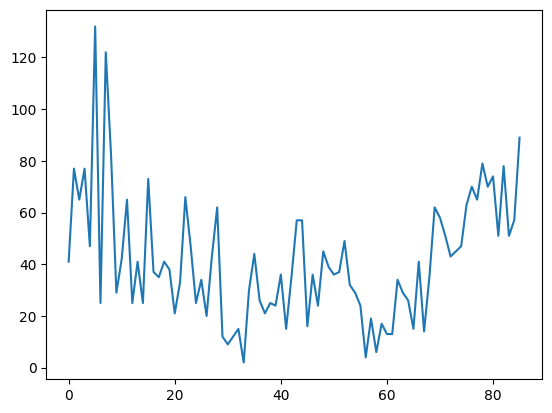

In [47]:
idx = np.sum(np.isnan(beta_valume_clean_2d), axis=0)

plt.plot(idx[:-4])

In [42]:
idx[-1]

np.int64(7702)

In [43]:
beta_valume_clean_2d.shape

(314734, 90)

In [ ]:
np.isnan(beta_valume_clean_2d)

In [37]:
np.isnan(beta_valume_clean_2d)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(314734, 90))

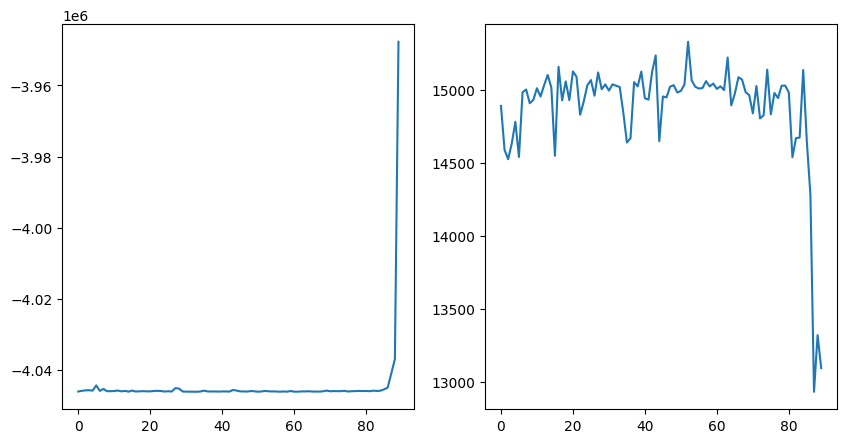

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(beta_reduced[0, :])
ax[1].plot(beta_reduced[587, :])

In [ ]:
def calculate_matrices(beta_valume_clean_2d, clean_active_bold, mask_2d, behavior_matrix,
                       trial_indices=None, trial_len=trial_len, pca_components=None, pca_mean=None):
    
    num_trials = beta_valume_clean_2d.shape[-1]
    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())
    behavior_subset = behavior_matrix[trial_idx]
    X = clean_active_bold[:, trial_idx, :]

    # ----- apply PCA -----
    print("PCA...", flush=True)
    X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)

    if pca_components is None or pca_mean is None:
        pca = PCA()
        X_pca_full = pca.fit_transform(X_reshap.T).astype(np.float32)
        components = pca.components_.astype(np.float32)
        mean = pca.mean_.astype(np.float32)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.searchsorted(cumulative_variance, 0.95) + 1
        components = components[:n_components]
        X_pca = X_pca_full[:, :n_components]
    else:
        components = pca_components.astype(np.float32)
        mean = pca_mean.astype(np.float32)
        n_components = components.shape[0]
        X_centered = X_reshap.T - mean
        X_pca = (X_centered @ components.T).astype(np.float32)

    beta_reduced = np.nan_to_num(beta_valume_clean_2d.T - mean) @ components.T
    beta_reduced = beta_reduced.T
    print("Beta reduced shape:", beta_reduced.shape, flush=True)

    # ----- L_task (same idea as yours) -----
    print("L_task...", flush=True)
    beta_selected = beta_reduced[:, trial_idx]

    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(np.abs(beta_selected), axis=-1, dtype=np.float64)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)

    L_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0 # avoid division by zero
    L_task[v] = (1.0 / mean_beta[v]).astype(np.float32)

    # ----- L_var_bold: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    X_pca = X_pca[:, :n_components].T
    num_trials = len(trial_idx)
    X_bold = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
    L_var_bold = np.zeros((X_bold.shape[0], X_bold.shape[0]), dtype=np.float32)

    for i in range(num_trials-1):
        x1 = X_bold[:, i, :]
        x2 = X_bold[:, i+1, :]
        L_var_bold += (x1-x2) @ (x1-x2).T
    L_var_bold /= (num_trials - 1)

    # ----- L_behavior: derived from behaviour regression weights -----
    print("L_behavior...", flush=True)
    behavior_plot_components = {0, 1, 2}  # adjust for components of interest
    behavior_plot_dir = "behavior_fits"
    behavior_penalty, behavior_weight_avg, results = _compute_behavior_term(
        X_bold,
        behavior_subset,
        plot_components=behavior_plot_components,
        plot_dir=behavior_plot_dir,
    )
    print(f"behavior_weight_avg: {behavior_weight_avg.shape}", flush=True)
    behavior_weight_metric = behavior_weight_avg
    # if behavior_weight_avg.shape[1] > 1:
    #     behavior_weight_metric = behavior_weight_avg[:, 1]
    # else:
    #     behavior_weight_metric = np.zeros(behavior_weight_avg.shape[0], dtype=np.float32)

    L_behavior = np.zeros_like(behavior_weight_metric, dtype=np.float32)
    valid_behav = np.isfinite(behavior_weight_metric) & (np.abs(behavior_weight_metric) > 0)
    L_behavior[valid_behav] = (1.0 / np.abs(behavior_weight_metric[valid_behav])).astype(np.float32)
    print(np.min(L_behavior), np.max(L_behavior), flush=True)

    # ----- L_var_beta: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    num_trials = len(trial_idx)
    X_beta = beta_reduced
    L_var_beta = np.zeros((X_beta.shape[0], X_beta.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = X_beta[:, i]
        x2 = X_beta[:, i+1]
        diff = x1 - x2
        L_var_beta += np.outer(diff, diff)  
    L_var_beta /= (num_trials - 1)
    

    selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
    return (L_task, L_var_bold, L_var_beta, L_behavior, behavior_weight_avg, 
            behavior_penalty, selected_BOLD_flat, components, mean, results)

